In [1]:
from hashlib import sha1
from time import time

import numpy as np
import numpy.typing as npt
import pandas as pd
from scipy.linalg import solve_triangular

# Hiperparâmetros para geração das matrizes de teste

In [2]:
def generate_random_system(shape: tuple[int, int]):
    n, m = shape
    mat = np.random.randint(-10, 11, shape)
    vec = np.random.randint(-10, 11, n)
    return (mat, vec), {
        "n": n,
        "m": m,
        "matrix_hash": sha1(mat.data).hexdigest(),
        "vector_hash": sha1(vec.data).hexdigest(),
        "type": "Random",
        "rank": np.linalg.matrix_rank(mat),
        "is_square": n == m,
    }

In [3]:
N_FACTORS = [1, 2, 5, 10]
matrix_dict = dict[str, npt.NDArray]()
vector_dict = dict[str, npt.NDArray]()
dataframe_dict_list = list[dict]()

# Matrizes quadradas e depois com proporção 5:3
for f in N_FACTORS:
    n = 5 * f
    m = 5 * f
    ((mat, vec), t_dict) = generate_random_system((n, m))
    matrix_dict[t_dict["matrix_hash"]] = mat
    vector_dict[t_dict["vector_hash"]] = vec
    dataframe_dict_list.append(t_dict)
    # ============================================================
    n = 5 * f
    m = 3 * f
    ((mat, vec), t_dict) = generate_random_system((n, m))
    matrix_dict[t_dict["matrix_hash"]] = mat
    vector_dict[t_dict["vector_hash"]] = vec
    dataframe_dict_list.append(t_dict)

In [4]:
matrices_df = pd.DataFrame(
    data=dataframe_dict_list
)
matrices_df

,n,m,matrix_hash,vector_hash,type,rank,is_square
0,5,5,dc128b7e1f1c7f791ee72ec5809bc5165176e766,464e5d1e7d697d3ab34b88824c02f26ecece6eef,Random,5,True
1,5,3,b7059342d49f3340007693083c60b85b5dacf0f0,c90f49cf5aed7e9d8364a7cc971a2c474efc90b9,Random,3,False
2,10,10,b020698af952b97769c3169acc5889ab239d3d31,308a7df927ac143f5359ae1c94368f688ed5c878,Random,10,True
3,10,6,105e51968878f95bec0e599b1a0b602f2e54ffdb,2951f2bb6ad35366520656047673670ad88519f7,Random,6,False
4,25,25,d0f0f48e7e06bfa1ce124c032991077262ba5e74,d0e33e7184e2d259a2236451377c2a5ab6c30f03,Random,25,True
5,25,15,ab747bed5b072125c0e04abe46c95f7d88a4e651,efab09c69b9dff6ae5185ac8221fded7175a0081,Random,15,False
6,50,50,e00b034ce91fb650dadb811abf4f5e435a8e1642,a40e9c5ebbff977d04ae55b9ba24f0cce4d409ed,Random,50,True
7,50,30,9925d8a446e2694930f37321e1b75fb74b9102bc,94496247e44f3a8e943cc31062958863c3ed043b,Random,30,False


# Normal equations

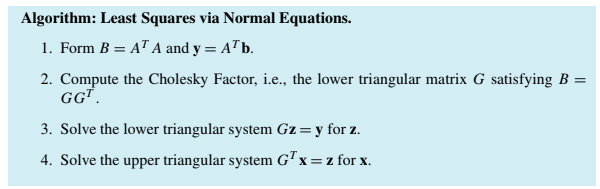

Note que caso a Decomposição Cholesky não seja possível, o método das equações normais não poderá ser utilizado.

In [5]:
def solve_by_normal_eq(matrix_df_row):
    t_start = time()
    A = matrix_dict[matrix_df_row["matrix_hash"]]
    b = vector_dict[matrix_df_row["vector_hash"]]
    B = A.T @ A
    y = A.T @ b
    G = np.linalg.cholesky(B)
    z = solve_triangular(G, y, lower=True)
    x = solve_triangular(G.T, z)
    t_end = time()
    return {
        "resid": np.float64(np.linalg.vector_norm(b - A @ x, ord=2)),
        "time": np.float64((t_end - t_start) * 1000)
    }

In [6]:
normal_eq_dict_list = list[dict]()
for (_, row) in matrices_df.iterrows():   
    normal_eq_dict_list.append(solve_by_normal_eq(row))
normal_eq_df = pd.DataFrame(data=normal_eq_dict_list)
display(pd.concat([matrices_df, normal_eq_df], axis=1))

,n,m,matrix_hash,vector_hash,type,rank,is_square,resid,time
0,5,5,dc128b7e1f1c7f791ee72ec5809bc5165176e766,464e5d1e7d697d3ab34b88824c02f26ecece6eef,Random,5,True,2.401780e-15,0.321388
1,5,3,b7059342d49f3340007693083c60b85b5dacf0f0,c90f49cf5aed7e9d8364a7cc971a2c474efc90b9,Random,3,False,9.623244e+00,0.089169
2,10,10,b020698af952b97769c3169acc5889ab239d3d31,308a7df927ac143f5359ae1c94368f688ed5c878,Random,10,True,6.366449e-14,0.101805
3,10,6,105e51968878f95bec0e599b1a0b602f2e54ffdb,2951f2bb6ad35366520656047673670ad88519f7,Random,6,False,1.149132e+01,0.072479
4,25,25,d0f0f48e7e06bfa1ce124c032991077262ba5e74,d0e33e7184e2d259a2236451377c2a5ab6c30f03,Random,25,True,7.342797e-14,0.100851
5,25,15,ab747bed5b072125c0e04abe46c95f7d88a4e651,efab09c69b9dff6ae5185ac8221fded7175a0081,Random,15,False,2.291607e+01,0.075102
6,50,50,e00b034ce91fb650dadb811abf4f5e435a8e1642,a40e9c5ebbff977d04ae55b9ba24f0cce4d409ed,Random,50,True,4.308200e-13,0.209808
7,50,30,9925d8a446e2694930f37321e1b75fb74b9102bc,94496247e44f3a8e943cc31062958863c3ed043b,Random,30,False,3.029009e+01,0.101089


Nota-se que em matrizes não-quadradas, o método possui um um resíduo múltiplas ordens de magnitude maior.

# QR decomposition

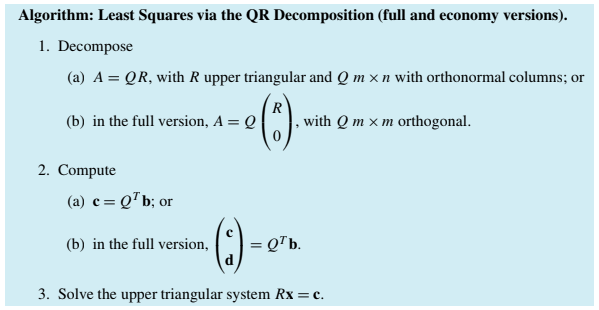

In [7]:
def solve_by_qr(matrix_df_row):
    t_start = time()
    A = matrix_dict[matrix_df_row["matrix_hash"]]
    b = vector_dict[matrix_df_row["vector_hash"]]
    Q, R = np.linalg.qr(A) # Reduced QR by default on Numpy
    c = Q.T @ b
    x = solve_triangular(R, c)
    t_end = time()
    return {
        "resid": np.float64(np.linalg.vector_norm(b - A @ x, ord=2)),
        "time": np.float64((t_end - t_start) * 1000)
    }

In [8]:
qr_decomp_dict_list = list[dict]()
for (_, row) in matrices_df.iterrows():   
    qr_decomp_dict_list.append(solve_by_qr(row))
qr_decomp_df = pd.DataFrame(data=qr_decomp_dict_list)
display(pd.concat([matrices_df, qr_decomp_df], axis=1))

,n,m,matrix_hash,vector_hash,type,rank,is_square,resid,time
0,5,5,dc128b7e1f1c7f791ee72ec5809bc5165176e766,464e5d1e7d697d3ab34b88824c02f26ecece6eef,Random,5,True,4.446440e-15,0.223875
1,5,3,b7059342d49f3340007693083c60b85b5dacf0f0,c90f49cf5aed7e9d8364a7cc971a2c474efc90b9,Random,3,False,9.623244e+00,0.092745
2,10,10,b020698af952b97769c3169acc5889ab239d3d31,308a7df927ac143f5359ae1c94368f688ed5c878,Random,10,True,5.384296e-14,0.099897
3,10,6,105e51968878f95bec0e599b1a0b602f2e54ffdb,2951f2bb6ad35366520656047673670ad88519f7,Random,6,False,1.149132e+01,0.084639
4,25,25,d0f0f48e7e06bfa1ce124c032991077262ba5e74,d0e33e7184e2d259a2236451377c2a5ab6c30f03,Random,25,True,6.468171e-14,0.114918
5,25,15,ab747bed5b072125c0e04abe46c95f7d88a4e651,efab09c69b9dff6ae5185ac8221fded7175a0081,Random,15,False,2.291607e+01,0.087261
6,50,50,e00b034ce91fb650dadb811abf4f5e435a8e1642,a40e9c5ebbff977d04ae55b9ba24f0cce4d409ed,Random,50,True,1.284594e-13,0.169992
7,50,30,9925d8a446e2694930f37321e1b75fb74b9102bc,94496247e44f3a8e943cc31062958863c3ed043b,Random,30,False,3.029009e+01,0.110388


Observa-se o mesmo padrão de erro

# SVD decomposition

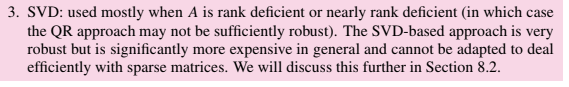

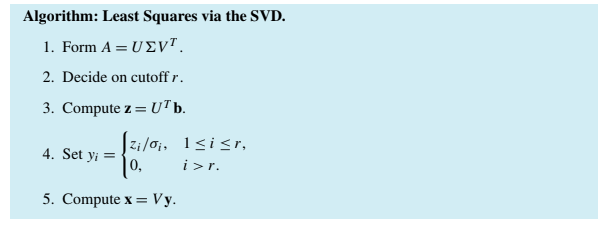

In [9]:
def solve_by_svd(matrix_df_row, r:int):
    t_start = time()
    A = matrix_dict[matrix_df_row["matrix_hash"]]
    b = vector_dict[matrix_df_row["vector_hash"]]
    U, S, Vt = np.linalg.svd(A)
    z = U.T @ b
    rank = min(r, len(S))
    y = np.zeros(len(S))
    y[:rank] = z[:rank] / S[:rank]
    x = Vt.T @ y
    t_end = time()
    return {
        "resid": np.float64(np.linalg.vector_norm(b - A @ x, ord=2)),
        "time": np.float64((t_end - t_start) * 1000)
    }

In [10]:
svd_decomp_dict_list = list[dict]()
for (_, row) in matrices_df.iterrows():
    svd_decomp_dict_list.append(solve_by_svd(row, row["m"]))
svd_decomp_df = pd.DataFrame(data=svd_decomp_dict_list)
display(pd.concat([matrices_df, svd_decomp_df], axis=1))

,n,m,matrix_hash,vector_hash,type,rank,is_square,resid,time
0,5,5,dc128b7e1f1c7f791ee72ec5809bc5165176e766,464e5d1e7d697d3ab34b88824c02f26ecece6eef,Random,5,True,1.246618e-14,0.136375
1,5,3,b7059342d49f3340007693083c60b85b5dacf0f0,c90f49cf5aed7e9d8364a7cc971a2c474efc90b9,Random,3,False,9.623244e+00,0.056744
2,10,10,b020698af952b97769c3169acc5889ab239d3d31,308a7df927ac143f5359ae1c94368f688ed5c878,Random,10,True,5.229893e-14,0.055790
3,10,6,105e51968878f95bec0e599b1a0b602f2e54ffdb,2951f2bb6ad35366520656047673670ad88519f7,Random,6,False,1.149132e+01,0.047445
4,25,25,d0f0f48e7e06bfa1ce124c032991077262ba5e74,d0e33e7184e2d259a2236451377c2a5ab6c30f03,Random,25,True,1.534172e-13,0.135422
5,25,15,ab747bed5b072125c0e04abe46c95f7d88a4e651,efab09c69b9dff6ae5185ac8221fded7175a0081,Random,15,False,2.291607e+01,0.081301
6,50,50,e00b034ce91fb650dadb811abf4f5e435a8e1642,a40e9c5ebbff977d04ae55b9ba24f0cce4d409ed,Random,50,True,2.696404e-13,2.184391
7,50,30,9925d8a446e2694930f37321e1b75fb74b9102bc,94496247e44f3a8e943cc31062958863c3ed043b,Random,30,False,3.029009e+01,0.205517


Novamente, observamos uma dificuldade em calcular corretamente sistemas não-quadrados. Foi utilizado como _cut-off_ a quantidade de colunas na matriz original.